In [83]:
from src.doc2vec import Doc2VecWrapper
from src.utils import load_data
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

## Train doc2vec

In [98]:
doc2vec = Doc2VecWrapper()

jobs = load_data(kind="processed")
jobs['description'] = jobs['description'].apply(ast.literal_eval)
jobs_descriptions = jobs['description'].tolist()

doc2vec = Doc2VecWrapper()
doc2vec.init(vector_size=100, alpha=0.025,
              min_alpha=0.00025, min_count=10, epochs=500)
doc2vec.fit(jobs_descriptions)
doc2vec.train()

Training doc2vec: 100%|##########| 500/500 [02:04<00:00,  4.03it/s]


## Clustering

### KMEANS

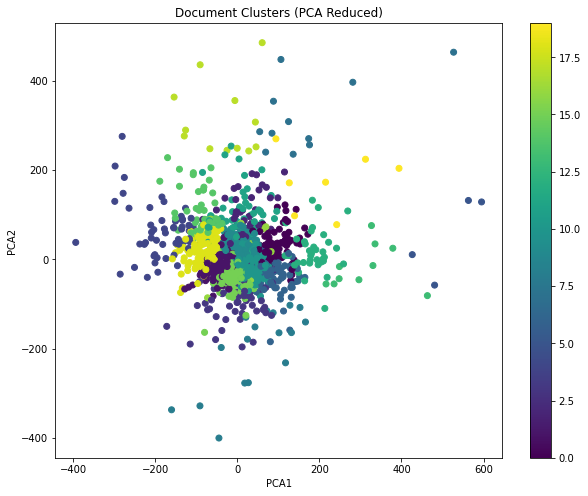

In [93]:
# Cluster similar documents
vectors = [doc2vec.model.dv[i] for i in range(len(doc2vec.model.dv))]
vectors = np.array(vectors)

# Put the embeddings into the original dataframe
jobs['embeddings'] = vectors.tolist()

# Cluster the embeddings

kmeans = KMeans(n_clusters=20, random_state=42, n_init=10).fit(jobs['embeddings'].tolist())
jobs['cluster'] = kmeans.labels_.tolist()

# Plot the clusters

# Convert embeddings to a numpy array (if not already)
embeddings = np.array(jobs['embeddings'].tolist())

# Apply PCA and reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=jobs['cluster'], cmap='viridis')
plt.title('Document Clusters (PCA Reduced)')
plt.colorbar(scatter)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [85]:
# Explained variance by the first two components

print("Explained variance by the first two components: ", pca.explained_variance_ratio_)
print("Total explained variance: ", sum(pca.explained_variance_ratio_))


Explained variance by the first two components:  [0.55010338 0.28978221]
Total explained variance:  0.8398855893199417


### DBSCAN

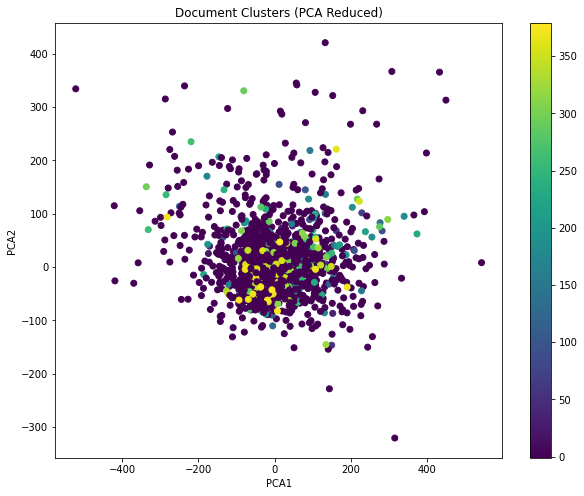

In [74]:
# Use DBSCAN instead of KMeans

dbscan = DBSCAN(eps=0.01, min_samples=1).fit(jobs['embeddings'].tolist())
jobs['cluster'] = dbscan.labels_.tolist()

# Convert embeddings to a numpy array (if not already)
embeddings = np.array(jobs['embeddings'].tolist())

# Apply PCA and reduce to 2 dimensions

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot

plt.figure(figsize=(10, 8))

scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=jobs['cluster'], cmap='viridis')
plt.title('Document Clusters (PCA Reduced)')
plt.colorbar(scatter)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


### GAUSSIAN MIXTURE

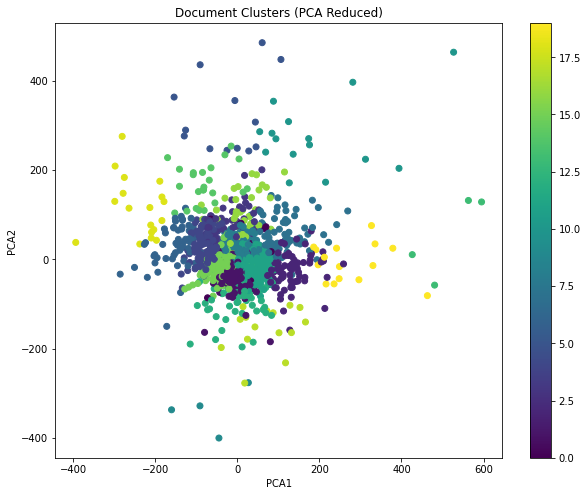

In [94]:

gmm = GaussianMixture(n_components=20, random_state=42).fit(jobs['embeddings'].tolist())
jobs['cluster'] = gmm.predict(jobs['embeddings'].tolist())

embeddings = np.array(jobs['embeddings'].tolist())

# Apply PCA and reduce to 2 dimensions

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))

scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=jobs['cluster'], cmap='viridis')
plt.title('Document Clusters (PCA Reduced)')
plt.colorbar(scatter)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

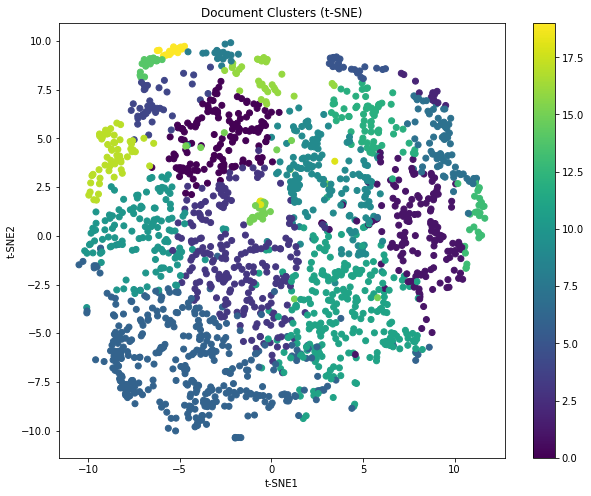

In [81]:

# Optionally start with PCA reduction
pca = PCA(n_components=50)  # Reducing to a lower dimension like 50 if not already done
embeddings_reduced = pca.fit_transform(embeddings)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_tsne = tsne.fit_transform(embeddings_reduced)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=jobs['cluster'], cmap='viridis')
plt.title('Document Clusters (t-SNE)')
plt.colorbar(scatter)
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

## Evaluate

In [96]:
# Ground Truth Clusters

gt = pd.read_csv('clusters/ground_truth.csv')

# Calculate NMI between ground truth and KMeans clusters

from sklearn.metrics.cluster import normalized_mutual_info_score
merged_df = pd.merge(jobs, gt, on='id', suffixes=('_your_cluster', '_ground_truth'))

# Calculate NMI
nmi_score = normalized_mutual_info_score(merged_df['cluster_your_cluster'], merged_df['cluster_ground_truth'])

print("NMI Score:", nmi_score)


NMI Score: 0.04036228482656287


In [97]:
# David boulding score

from sklearn.metrics.cluster import davies_bouldin_score

dbs_score = davies_bouldin_score(jobs['embeddings'].tolist(), jobs['cluster'].tolist())

print("DBS Score:", dbs_score)

DBS Score: 1.3834910789183925


## Save clusters

In [91]:
# Save clusters in a format "id, cluster"

#NAME = 'doc2vec_gmm_clusters'
#NAME = 'doc2vec_dbscan_clusters'
NAME = 'doc2vec_kmeans_clusters'

jobs[['id', 'cluster']].to_csv(f'clusters/{NAME}.csv', index=False)